# Load Image

This notebook shows how to load data we want from .csv file, and download data from google storage.

**Note: You can only run this notebook after having the full dataset.**

In [0]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import math
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import pandas as pd
from torch.utils.data.dataset import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.image as mpimg
plt.ion()   # interactive mode

## Low resolution data preparation

This part is implemented in Matlab. We get the high resolution data, which has dimension 256×320×320. Then we do 3D Fourier Transform on the 3D image and get the k-space (which is a spectral space) data. We do truncation on the peripheral part (which represents the resolution) of k-space with 256 slices to downgrade the resolution. The factor the paper use is 2. So, it takes the k-space size to 160×160. We take more aggressive number: 5, which takes the k-space size to 64×64. Then we do 3D inverse Fourier Transform to get back to the image space. Linear interpolation is applied to recover the downgraded images to the original size.

All these data were online-fetched from Amazon website service (AWS), first transferred to google storage by sending storage transfer request, then went through the truncation code, stored in respective folders in google storage.

<img style="float: center;" src="./example_images/k-space.jpg" width="60%">

## Test of data loading with online fetching, and patching

In [0]:
from ecbm6040.dataloader.CustomDatasetFromCSV import CustomDatasetFromCSV

from ecbm6040.patching.patchloader import patching

 **Parameter setting**

In [0]:
# set pathes
vm_PATH = "./tmp_data/"
gs_PATH = "gs://hz2538/superresolution/HCP_130/"
id_csv = './csv/id_hcp_test.csv'

# set shuffle and stablize random_seed
shuffle_dataset = True
random_seed= 999

# set percentage of data spliting
train_split= 0.7
validate_split = 0.1
evaluate_split = 0.1
test_split = 0.1

# set batch size, it controls the number of samples once download
batch_size = 2

# set patch size, it controls the number of patches once send into the model
patch_size = 2

# set the size of one patch (eg. 64 means a cubic patch with size: 64*64*64)
cube_size = 64

# set the usage of a patch cluster. usage < 1.0 would mean we choose to randomly give up some patches  
usage = 0.1

# set GPU device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

**Split data, create dataloaders**

In [4]:
# load data from csv
dataset = CustomDatasetFromCSV(id_csv,vm_PATH,gs_PATH)
dataset_size = len(dataset)

# get indices for spliting train, valiadate, evaluate, test sets
train_size = math.ceil(train_split * dataset_size)
validate_size = int(validate_split * dataset_size)
evaluate_size = int(evaluate_split * dataset_size)
test_size = int(dataset_size - train_size - validate_size - evaluate_size)

indices = list(range(dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices = indices[:train_size]
loc_val = train_size + validate_size
val_indices = indices[train_size:loc_val]
loc_eval = loc_val + evaluate_size
eval_indices = indices[loc_val:loc_eval]
test_indices = indices[loc_eval:]
print('training set number:{}'.format(len(train_indices)))
print('validation set number:{}'.format(len(val_indices)))
print('evaluation set number:{}'.format(len(eval_indices)))
print('test set number:{}'.format(len(test_indices)))


training set number:91
validation set number:13
evaluation set number:13
test set number:13


In [0]:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)
eval_sampler = SubsetRandomSampler(eval_indices)
test_sampler = SubsetRandomSampler(test_indices)

train_loader = torch.utils.data.DataLoader(dataset=dataset, 
                                        batch_size=batch_size, 
                                        sampler=train_sampler,
                                        shuffle=False)
validation_loader = torch.utils.data.DataLoader(dataset=dataset, 
                                        batch_size=batch_size, 
                                        sampler=valid_sampler,
                                        shuffle=False)
eval_loader = torch.utils.data.DataLoader(dataset=dataset, 
                                        batch_size=batch_size, 
                                        sampler=eval_sampler,
                                        shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=dataset, 
                                        batch_size=batch_size, 
                                        sampler=test_sampler,
                                        shuffle=False)


dataloaders={'train':train_loader, 'val':validation_loader}
dataset_sizes={'train':len(train_sampler), 'val':len(valid_sampler)}

**Patching**

In this project, we treat data differently. Considering the huge size of image: 256×320×320, it's not possible to input a whole image. We induce patching technique. 


<img style="float: center;" src="./example_images/patching.png" width="50%">

**Problem**: What if the cubes are totally noise?

**An example of patch loading**

In [6]:
for lr_data, hr_data in dataloaders['val']:
    print(lr_data.shape)
    patch_loader=patching(lr_data, hr_data, patch_size = patch_size, cube_size = cube_size, usage=usage, is_training=True)
    for lr_patches, hr_patches in patch_loader:
        print(lr_patches.shape)
        

torch.Size([2, 256, 320, 320])
torch.Size([2, 1, 64, 64, 64])
torch.Size([2, 1, 64, 64, 64])
torch.Size([2, 1, 64, 64, 64])
torch.Size([2, 1, 64, 64, 64])
torch.Size([2, 1, 64, 64, 64])
torch.Size([2, 1, 64, 64, 64])
torch.Size([2, 1, 64, 64, 64])
torch.Size([2, 1, 64, 64, 64])
torch.Size([2, 1, 64, 64, 64])
torch.Size([2, 1, 64, 64, 64])
torch.Size([2, 256, 320, 320])
torch.Size([2, 1, 64, 64, 64])
torch.Size([2, 1, 64, 64, 64])
torch.Size([2, 1, 64, 64, 64])
torch.Size([2, 1, 64, 64, 64])
torch.Size([2, 1, 64, 64, 64])
torch.Size([2, 1, 64, 64, 64])
torch.Size([2, 1, 64, 64, 64])
torch.Size([2, 1, 64, 64, 64])
torch.Size([2, 1, 64, 64, 64])
torch.Size([2, 1, 64, 64, 64])
torch.Size([2, 256, 320, 320])
torch.Size([2, 1, 64, 64, 64])
torch.Size([2, 1, 64, 64, 64])
torch.Size([2, 1, 64, 64, 64])
torch.Size([2, 1, 64, 64, 64])
torch.Size([2, 1, 64, 64, 64])
torch.Size([2, 1, 64, 64, 64])
torch.Size([2, 1, 64, 64, 64])
torch.Size([2, 1, 64, 64, 64])
torch.Size([2, 1, 64, 64, 64])
torch.Si

## Image examples

**Example 1: Input HR/LR images**

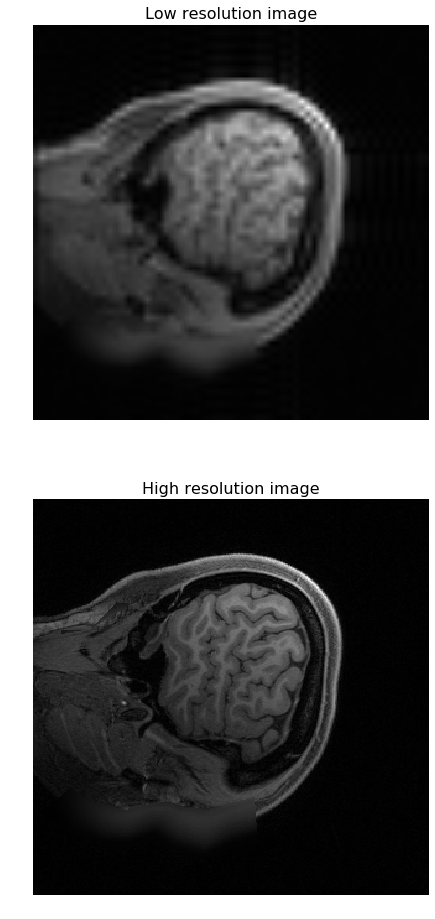

In [7]:
f = plt.figure(figsize=(8,16))
sp = f.add_subplot(2,1,1)
sp.axis('Off')
sp.set_title('Low resolution image', fontsize=16)
plt.imshow(lr_data[0,50,:,:],cmap='gray')
sp = f.add_subplot(2,1,2)
sp.axis('Off')
sp.set_title('High resolution image', fontsize=16)
plt.imshow(hr_data[0,50,:,:],cmap='gray')

**Example 2: HR/LR patches**

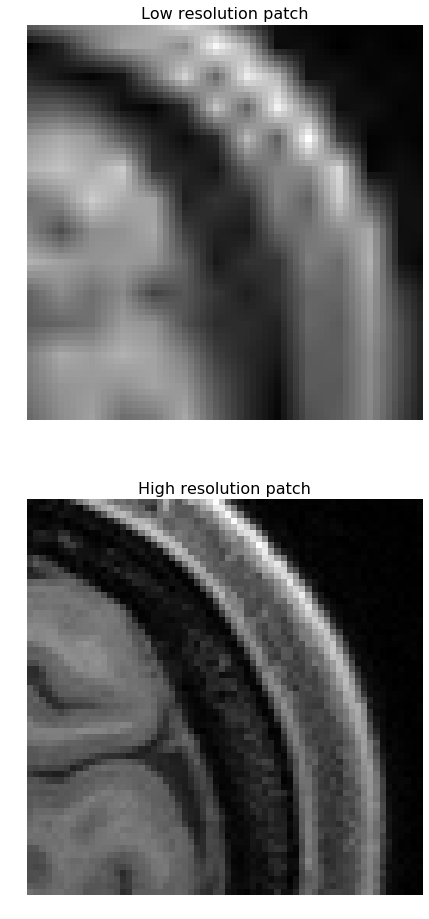

In [8]:
f = plt.figure(figsize=(8,16))
sp = f.add_subplot(2,1,1)
sp.axis('Off')
sp.set_title('Low resolution patch', fontsize=16)
plt.imshow(lr_patches[0,0,50,:,:],cmap='gray')
sp = f.add_subplot(2,1,2)
sp.axis('Off')
sp.set_title('High resolution patch', fontsize=16)
plt.imshow(hr_patches[0,0,50,:,:],cmap='gray')